# Lesson 09 - Flow over a cylinder with Source Panels 

We have used flow singularities to represent simple gemometries (Rankine Oval) or circular cylinder immersed in a freestream 

What isf we want to represent an arbitrary geometry? We will learn that in this lesson. This method consists of representing geometry of a body by a series of linear segments or panels that correspond to source sheets 



In [2]:
import math
import numpy 
from scipy import integrate 
from matplotlib import pyplot
# embed those figures 
%matplotlib inline 

In [3]:
u_inf = 1.0 #freestream speed

## Defing the geometry 

We want a circular cylinder of unit radius 

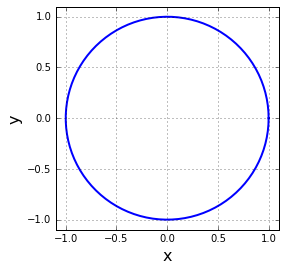

In [4]:
#define the cylinder 
R = 1.0 
theta = numpy.linspace(0, 2*math.pi, 100) #angles in radians
x_cylinder, y_cylinder = R*numpy.cos(theta), R*numpy.sin(theta) #coordinates of a circle

#plot the cylinder 
size =4
pyplot.figure(figsize = (size,size))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize =16)
pyplot.plot(x_cylinder, y_cylinder, color = 'b', linestyle = '-', linewidth = 2)
pyplot.xlim(-1.1, 1.1)
pyplot.ylim(-1.1, 1.1);

## Discretization into panels 

A panel is represented by the two end points (xa, ya) and (xb, yb) and its strength sigma. The orientaton is defined by angle between the x-axis and the normal in a counter-clockwise sense 

Each panel is represented as a source sheet. We need to caclculate the source strength of the sheet for the correct streamlines to arise

We will also want the tangential velocity (the normal velocity on the body is zero for inviscid flow) and the pressure coefficient

We are going to create a class that contains all the information about the panel and calculates the center point, length, and the normal vector 

It will initialize the source strength, tangential velocity, and the pressure coefficient as zero. 

In [5]:
class Panel: 
    """
    contains info related to a panel 
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Initialized the panel 
        
        Sets the end-points and calculated the center, length, and angle 
        (with the x-axis) of the panel 
        Initializes the strength of the source-sheet, the tangential velocity, 
        and the pressure coefficient to zeo
        
        Parameters
        _----------
        xa (float): x-coordinate of the first end-point 
        ya (float): y-coordinate of the first end point 
        xb (float): x-coordinate of the second end-point 
        yb (float): y-coordinate of the second end point 
        """
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2       # control-point (center-point)
        self.length = math.sqrt((xb-xa)**2+(yb-ya)**2)     # length of the panel
        
        # orientation of the panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.:
            self.beta = math.acos((yb-ya)/self.length)
        elif xb-xa > 0.:
            self.beta = math.pi + math.acos(-(yb-ya)/self.length)
        
        self.sigma = 0.                             # source strength
        self.vt = 0.                                # tangential velocity
        self.cp = 0.       
        
        

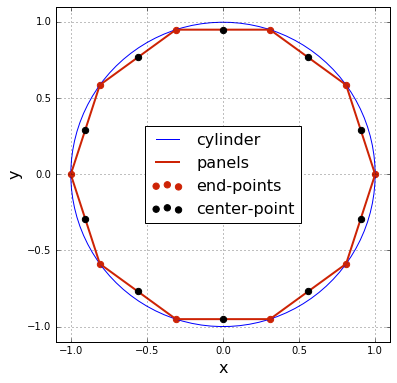

In [6]:
N_panels =10  # number of panels desired 

#define the end points of the panels 
x_ends = R*numpy.cos(numpy.linspace(0,2*math.pi, N_panels+1))
y_ends = R*numpy.sin(numpy.linspace(0, 2*math.pi, N_panels+1))

#define the panels 
panels = numpy.empty(N_panels, dtype=object)
for i in range(N_panels):
    panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])

# plot the panels 
size = 6 
pyplot.figure(figsize=(size,size))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize = 16)
pyplot.plot(x_cylinder, y_cylinder, label='cylinder', color = 'b', linestyle = '-', 
           linewidth = 1)
pyplot.plot(x_ends, y_ends, label= 'panels', color = '#CD2305', 
           linestyle = '-', linewidth =2)
pyplot.scatter([p.xa for p in panels], [p.ya for p in panels], 
              label = 'end-points', color = '#CD2305', s= 40)
pyplot.scatter([p.xc for p in panels], [p.yc for p in panels], 
              label = 'center-point', color = 'k', s=40, zorder =3)
pyplot.legend(loc='best', prop = {'size':16})
pyplot.xlim(-1.1, 1.1)
pyplot.ylim(-1.1, 1.1);

## Flow-tangency boundary condition 

In lesson 1, we found that the velocity potential of a single source  was sigma/2pi ln(r)  
This was calculated by integrating the radial velcoty (the integration also gives your a function  of theta, but it is only a constant by u(theta) = 0 

We will use the velocity potential in this lesson that we can easily express that the velocity is tangent to the panel and that the normal velocity =0 

We choose the point to enforce that the velocity tangency condition as the center of the panel ( we call this a control point) 

We can see that the velocity potential is the integral over the panel of the equation of the single source 

The superposition of the potential of each panel gives the total potential the sum of all the panel contributions and that makes it a sum of the integrals.

We can easily add a freestream as well by just adding the velocity potential 
of a freestream 

In [7]:
def integral_normal(p_i, p_j): 
    """
    Evaluates the contributions of a panels at the center-point of another, 
    in the normal direction.
    
    Parameters
    ----------
    p_i: Panel object 
        Panel on which the contribution is calculated.
    p_j: panel object 
        Panel from the contribution is calculated 
        
    Returns
    --------
    Integral over the panel at the center point of the other. 
    """
    
    def integrand(s): 
        return ( (+(p_i.xc-(p_j.xa-math.sin(p_j.beta)*s))*math.cos(p_i.beta)
                 +(p_i.yc-(p_j.ya+math.cos(p_j.beta)*s))*math.sin(p_i.beta))
                /((p_i.xc-(p_j.xa-math.sin(p_j.beta)*s))**2
                 +(p_i.yc-(p_j.ya+math.cos(p_j.beta)*s))**2) )
    return integrate.quad(integrand,0.0, p_j.length)[0]


## Solving the system of equations 

[A][sigma] = [b]

when i and j are equal, the integral is 1/2
When i and j are NOT equal, the integral is defined above 

b is defined as -U_inf cos(Beta(i))


In [8]:
# computet the source influence matrix 
A = numpy.empty((N_panels, N_panels), dtype=float)
numpy.fill_diagonal(A,0.5)

for i, p_i in enumerate(panels): 
    for j, p_j in enumerate(panels): 
        if i != j: 
            A[i,j] = 0.5/math.pi*integral_normal(p_i,p_j)

#compute the RHS of the linear system
b = - u_inf*numpy.cos([p.beta for p in panels])

**enumerate()** is a built in function that allows us to have access to each element in panel in the array panels while keeping a count i (that starts from 0) to locate the element of A to fill 

Now we can easily solve the linear system of equations using the function **linalg.solve()** from Numpy 

In [9]:
# solve the linear system 
sigma = numpy.linalg.solve(A,b)

for i, panel in enumerate(panels):
    panel.sigma = sigma[i]

## Pressure coefficient on the surface 

we can calculate this using the panel methods and compare it the analytical solution 

In [10]:
def integral_tangential(p_i,p_j):
    """
    Evalucates the contribution of a panel at the center-point of another, 
    in the tangential direction. 
    
    Parameters
    -----------
    p_i: panel object 
        panel on which the contribution is calculated. 
    p_j: panel object 
        panel from which the contribution is calculated.
        
    Returns 
    -------
    integral over the panel at the center point of the other. 
    """
    def integrand(s): 
        return ( (- (p_i.xc-(p_j.xa-math.sin(p_j.beta)*s))*math.sin(p_i.beta)
                 +(p_i.yc-(p_j.ya+math.cos(p_j.beta)*s))*math.cos(p_i.beta))
               /((p_i.xc-(p_j.xa-math.sin(p_j.beta)*s))**2
                +(p_i.yc-(p_j.ya+math.cos(p_j.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, p_j.length)[0]

In [11]:
# compute the matrix of the linear system
A = numpy.empty((N_panels, N_panels), dtype=float)
numpy.fill_diagonal(A, 0.0)

for i, p_i in enumerate(panels):
    for j, p_j in enumerate(panels):
        if i != j:
            A[i,j] = 0.5/math.pi*integral_tangential(p_i, p_j)

# compute the RHS of the linear system
b = - u_inf * numpy.sin([panel.beta for panel in panels])

# compute the tangential velocity at each panel center-point
vt = numpy.dot(A, sigma) + b

for i, panel in enumerate(panels):
    panel.vt = vt[i]

In [12]:
# calculate the surface pressure coefficient
for panel in panels:
    panel.cp = 1.0 - (panel.vt/u_inf)**2

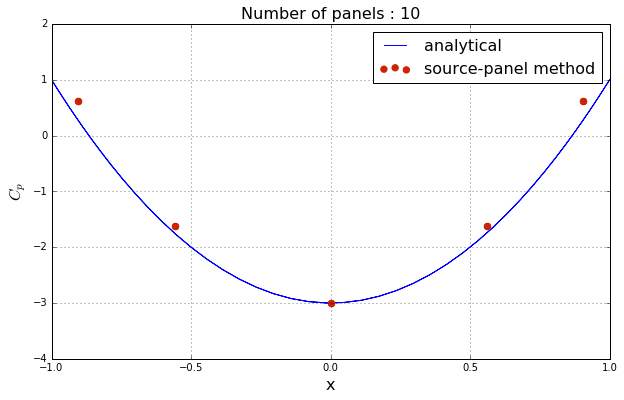

In [13]:
# calculate the analytical surface pressure coefficient
cp_analytical = 1.0 - 4*(y_cylinder/R)**2

# plot the surface pressure coefficient
pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot(x_cylinder, cp_analytical,
            label='analytical',
            color='b', linestyle='-', linewidth=1, zorder=1)
pyplot.scatter([p.xc for p in panels], [p.cp for p in panels],
               label='source-panel method',
               color='#CD2305', s=40, zorder=2)
pyplot.title('Number of panels : %d' % N_panels, fontsize=16)
pyplot.legend(loc='best', prop={'size':16})
pyplot.xlim(-1.0, 1.0)
pyplot.ylim(-4.0, 2.0);

## Challenge Task 

We want to visualize the stream lines on the cylinder. We wwant to calculate the velocity components in a cartesean grid 

Tasks - 
    - derive the cartesian velocity components 
    - create a mesh grid
    - compute the velocity field on the mesh grid
    - plot the results 
    - change the number of panels to imporve visalization 
    
I am going to use the number of panels 

In [64]:
# Defining a mesh grid 
R = 1.0
x_start,x_end = -5*R, 5*R
y_start, y_end = -5*R, 5*R

x = numpy.linspace(x_start,x_end, 30)
y = numpy.linspace(y_start,y_end, 30)

X,Y = numpy.meshgrid(x,y)


In [65]:
# Computing the velocity field on the meshgrid

def integral_u(p_i, X, Y):
    """ 
    Evaluates the contribution of a panel to the horizontal velocity 
    
    Parameters
    ----------
    p_i: Panel object 
        Panel from whihc the contribution is calculated. 
    X: 2D numpy array
        x-coordinates of the mesh grid 
    Y: 2D numpy array
        y-coordiantes of the meshgrid
        
    Returns
    --------
    The integral over the panel and contributing velocity to the field 
    """
    
    def integrand(s): 
        return ( (X-(p_i.xa-numpy.sin(p_i.beta)*s))
               /((X-(p_i.xa-numpy.sin(p_i.beta)*s))**2
                 +(Y-(p_i.ya+numpy.cos(p_i.beta)*s))**2) )
    return integrate.quad(integrand,0.0, p_i.length)[0]

def integral_v(p_i, X, Y):
    """
    Evaluates the contribution of a panel to the vertical velocity
    
    Parameters
    ----------
    p_i: Panel object
        Panel from which the contribution is calculated.
    X: 2D Numpy array
        x-coordinates of the meshgrid 
    Y: 2D numpy array 
        y-coordinates of the meshgrid 
    
    Returns 
    --------
    Integral over the panel at the points on meshg grid
    """
    
    def integrand(s):
        return ( (Y-(p_i.ya+numpy.cos(p_i.beta)*s))
               /((X-(p_i.xa-numpy.sin(p_i.beta)*s))**2
                 +(Y-(p_i.ya+numpy.cos(p_i.beta)*s))**2) )
    return integrate.quad(integrand,0.0, p_i.length)[0]

In [66]:
# compute the velocity components
vec_integral_u = numpy.vectorize(integral_u)
vec_integral_v = numpy.vectorize(integral_v)

u_panel = numpy.zeros((numpy.shape(X)),dtype=float)
v_panel = numpy.zeros((numpy.shape(Y)),dtype=float)
for i, p_i in enumerate(panels): 
    u_panel += p_i.sigma*0.5/math.pi*vec_integral_u(p_i, X,Y)
    v_panel += p_i.sigma*0.5/math.pi*vec_integral_v(p_i,X,Y)

# Superposition powers
u = u_inf + u_panel
v = v_panel


(-5.0, 5.0)

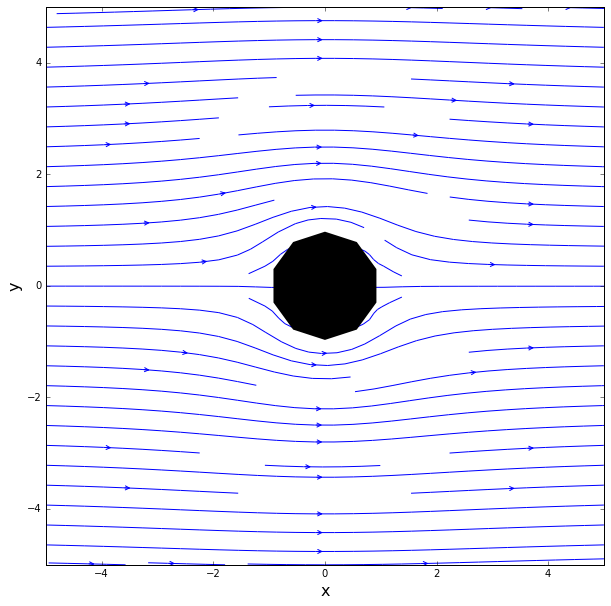

In [67]:
# plot the velocity field
width = 10
pyplot.figure(figsize=(width, width))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.streamplot(X, Y, u, v,
                  density=1, linewidth=1, arrowsize=1, arrowstyle='->')
pyplot.fill([panel.xc for panel in panels],
            [panel.yc for panel in panels],
            color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end);



In [72]:
# Changing the number of panels to make visualization better 

N_panels = 20 
x_ends = R*numpy.cos(numpy.linspace(0,2*math.pi, N_panels+1))
y_ends = R*numpy.sin(numpy.linspace(0,2*math.pi, N_panels+1))

#defining the panels 
panels = numpy.empty(N_panels, dtype=object)
for i in range(N_panels): 
    panels[i]= Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])


In [76]:
# computet the source influence matrix 
A = numpy.empty((N_panels, N_panels), dtype=float)
numpy.fill_diagonal(A,0.5)

for i, p_i in enumerate(panels): 
    for j, p_j in enumerate(panels): 
        if i != j: 
            A[i,j] = 0.5/math.pi*integral_normal(p_i,p_j)

#compute the RHS of the linear system
b = - u_inf*numpy.cos([p.beta for p in panels])


In [77]:
u_panel = numpy.zeros((numpy.shape(X)),dtype=float)
v_panel = numpy.zeros((numpy.shape(Y)),dtype=float)
for i, p_i in enumerate(panels): 
    u_panel += p_i.sigma*0.5/math.pi*vec_integral_u(p_i, X,Y)
    v_panel += p_i.sigma*0.5/math.pi*vec_integral_v(p_i,X,Y)

# Superposition powers
u = u_inf + u_panel
v = v_panel

# solve the linear system 
sigma = numpy.linalg.solve(A,b)

for i, panel in enumerate(panels):
    panel.sigma = sigma[i]

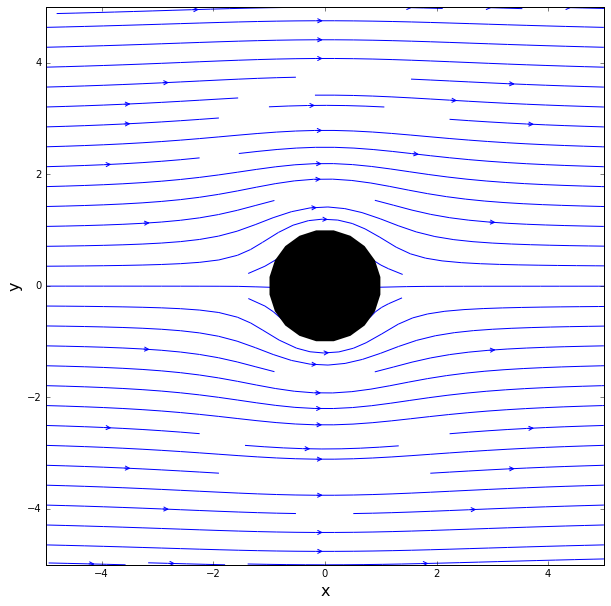

In [78]:
# plot the velocity field
width = 10
pyplot.figure(figsize=(width, width))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.streamplot(X, Y, u, v,
                  density=1, linewidth=1, arrowsize=1, arrowstyle='->')
pyplot.fill([panel.xc for panel in panels],
            [panel.yc for panel in panels],
            color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end);